In [61]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
from cobra.util import create_stoichiometric_matrix
import numpy as np
import escher

In [62]:
model = read_sbml_model('iMM904.xml') # insert model HERE

# heme

Our desired product, which we want to increase the flux to as much as possible, is heme:

In [63]:
model.metabolites.pheme_m # desired product

Metabolite identifier,pheme_m
Name,Protoheme C34H30FeN4O4
Memory address,0x01b1a5851a58
Formula,
Compartment,m
In 2 reaction(s),"FCLTm, HEMEOSm"


We see that the model does not contain information about the elemental composition of heme.

In [64]:
model.metabolites.pheme_m.annotation

{'sbo': 'SBO:0000247',
 'bigg.metabolite': 'pheme',
 'biocyc': 'META:PROTOHEME',
 'chebi': ['CHEBI:60344',
  'CHEBI:26355',
  'CHEBI:17627',
  'CHEBI:5651',
  'CHEBI:14957'],
 'inchi_key': 'KABFMIBPWCXCRK-RGGAHWMASA-J',
 'kegg.compound': 'C00032',
 'metanetx.chemical': 'MNXM249',
 'reactome.compound': ['917877', '71185', '189444']}

(...)But is is able to pull external references from databases like Kegg.

In [65]:
model.metabolites.pheme_m.reactions

frozenset({<Reaction FCLTm at 0x1b1a5e57fd0>,
           <Reaction HEMEOSm at 0x1b1a6e82160>})

We see that heme participates in two reactions only (https://www.genome.jp/kegg-bin/show_pathway?sce00860). One involed in its synthesis, and another reaction wherein heme is the substrate.

# The heme biosynthetic pathway

However, we want a lot of Protoheme C34H30FeN4O4 (id: pheme_m). Let's start by figuring out what the flux to heme currently is...

In [66]:
model.optimize().fluxes['FCLTm']

0.0

There is no flux by default. Just like we observed before, heme does not participate in any exchange reactions. Therefore, we will have to add the exchange reaction before we can analyse changes in the flux. 

In [67]:
model.add_boundary(model.metabolites.pheme_m, type='demand') # adds the exchange reaction for heme
with model: # measures the flux to heme (by default)
    model.objective = model.reactions.FCLTm
    print("The flux of the last reaction of the heme-pathway - and the maximum production of heme is: "+str(model.optimize().objective_value)+" [mmol gDW^-1 h^-1]")

The flux of the last reaction of the heme-pathway - and the maximum production of heme is: 0.550189393939394 [mmol gDW^-1 h^-1]


We look at the reactions heme is directely involved in... ...and then work backwards to glycine (https://www.genome.jp/kegg-bin/show_pathway?sce00860)

From glycine, eight reactions form the shorthest path (natively) in Baker's yeast. These are those reactions in cronological order. 

In [68]:
heme_1 = model.reactions.get_by_id('ALASm')
heme_2 = model.reactions.get_by_id('PPBNGS')
heme_3 = model.reactions.get_by_id('HMBS')
heme_4 = model.reactions.get_by_id('UPP3S') 
heme_12 = model.reactions.get_by_id('UPPDC1') 
heme_13 = model.reactions.get_by_id('CPPPGO')
heme_14 = model.reactions.get_by_id('PPPGOm') # second to last reaction in the heme biosynthesis
heme_15 = model.reactions.get_by_id('FCLTm')
heme_pathway = [heme_1,heme_2,heme_3,heme_4,heme_12,heme_13,heme_14,heme_15]

In [69]:
model.compartments

{'c': 'cytosol',
 'e': 'extracellular space',
 'm': 'mitochondria',
 'x': 'peroxisome/glyoxysome',
 'r': 'endoplasmic reticulum',
 'v': 'vacuole',
 'g': 'golgi apparatus',
 'n': 'nucleus'}

We see that our model, being a eukaryote, contains more than a few compartments. Heme is synthesised around the mitochondria - with some reactions taking place in the mitochondria and other reactions takning place in the cytosol. 

Let's optimise for the production of heme, and measure the fluxes of all eight reactions.

In [70]:
for i in range (0,len(heme_pathway)):
    with model:
        model.objective = heme_pathway[-1] # calculates the flux with heme as the objective
        print(model.optimize().fluxes[heme_pathway[i].id], heme_pathway[i].id, heme_pathway[i].reaction, heme_pathway[i].name)

4.401515151515152 ALASm gly_m + h_m + succoa_m --> 5aop_m + co2_m + coa_m 5 aminolevulinate synthase
2.200757575757576 PPBNGS 2.0 5aop_c --> 2.0 h2o_c + h_c + ppbng_c Porphobilinogen synthase
0.550189393939394 HMBS h2o_c + 4.0 ppbng_c --> hmbil_c + 4.0 nh4_c Hydroxymethylbilane synthase
0.550189393939394 UPP3S hmbil_c --> h2o_c + uppg3_c Uroporphyrinogen-III synthase
0.550189393939394 UPPDC1 4.0 h_c + uppg3_c --> 4.0 co2_c + cpppg3_c Uroporphyrinogen decarboxylase (uroporphyrinogen III)
0.550189393939394 CPPPGO cpppg3_c + 2.0 h_c + o2_c --> 2.0 co2_c + 2.0 h2o_c + pppg9_c Coproporphyrinogen oxidase (O2 required)
0.275094696969697 PPPGOm 3.0 o2_m + 2.0 pppg9_m --> 6.0 h2o_m + 2.0 ppp9_m Protoporphyrinogen oxidase  mitochondrial
0.550189393939394 FCLTm fe2_m + ppp9_m --> 2.0 h_m + pheme_m Ferrochelatase  mitochondrial


It is apprent that the fluxes are related to each other stoichiometrically, i.e. the PPPGOm reaction by Protoporphyrinogen oxidase has exactly half the flux of the FCLTm reaction catalysed by Ferrochelatase, because the substrate of the latter requires half the products of the former.

## Heme production and yield

In [56]:
model.metabolites.pheme_m.reactions

frozenset({<Reaction DM_pheme_m at 0x1b1a554a4e0>,
           <Reaction FCLTm at 0x1b1a5072fd0>,
           <Reaction HEMEOSm at 0x1b1a50ca7f0>})

In [71]:
model.reactions.DM_pheme_m

Reaction identifier,DM_pheme_m
Name,Protoheme C34H30FeN4O4 demand
Memory address,0x01b1a70181d0
Stoichiometry,pheme_m --> Protoheme C34H30FeN4O4 -->
GPR,
Lower bound,0
Upper bound,1000.0


In [73]:
medium = model.medium
with model:
    #medium['EX_glc__D_e'] = 0
    #medium['EX_ac_e'] = 10
    model.medium = medium
    model.objective = model.reactions.DM_pheme_m
    succ_production = model.optimize().objective_value
    print("Max. heme production [mmol gDW^-1 h^-1]:", succ_production)
    print("Theoretical max. yield [mmol-heme / mmol-[CARBON SOURCE]]:", succ_production / (-1*model.reactions.EX_glc__D_e.flux))

Max. heme production [mmol gDW^-1 h^-1]: 0.550189393939394
Theoretical max. yield [mmol-heme / mmol-[CARBON SOURCE]]: 0.055018939393939405


## Phenotypic phase plane analysis

In [74]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope

In [75]:
print(model.objective)

Maximize
1.0*BIOMASS_SC5_notrace - 1.0*BIOMASS_SC5_notrace_reverse_93090


In [76]:
ppp_succ = production_envelope(model,
                    reactions=[model.reactions.EX_glc__D_e],
                    objective=model.reactions.BIOMASS_SC5_notrace)

In [77]:
ppp_succ

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,EX_glc__D_e
0,EX_glc__D_e,0.0,0.0,NaN,0.287866,3.016363,NaN,-10.000000
1,EX_glc__D_e,0.0,0.0,NaN,0.275435,3.045455,NaN,-9.476780
2,EX_glc__D_e,0.0,0.0,NaN,0.263005,3.077947,NaN,-8.953560
3,EX_glc__D_e,0.0,0.0,NaN,0.250574,3.114473,NaN,-8.430341
4,EX_glc__D_e,0.0,0.0,NaN,0.238143,3.155832,NaN,-7.907121
5,EX_glc__D_e,0.0,0.0,NaN,0.225713,3.203053,NaN,-7.383901
6,EX_glc__D_e,0.0,0.0,NaN,0.213282,3.257476,NaN,-6.860681
7,EX_glc__D_e,0.0,0.0,NaN,0.200852,3.320885,NaN,-6.337461
8,EX_glc__D_e,0.0,0.0,NaN,0.188421,3.395707,NaN,-5.814241
9,EX_glc__D_e,0.0,0.0,NaN,0.175991,3.485327,NaN,-5.291022


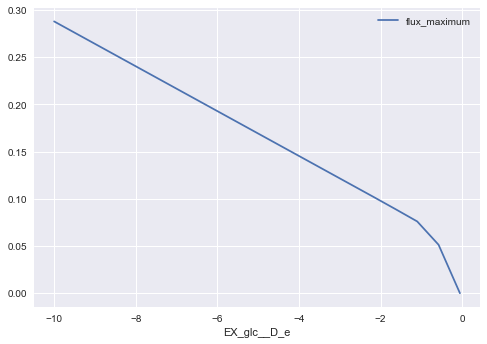

In [78]:
ppp_succ.plot(x='EX_glc__D_e', y='flux_maximum')

Use `production_envelope` to determine the optimal O2 uptake rate.

In [79]:
ppp_o2 = production_envelope(model,
                    reactions=[model.reactions.EX_o2_e],
                    objective=model.reactions.BIOMASS_SC5_notrace)

In [80]:
ppp_o2.EX_o2_e[ppp_o2.flux_maximum.idxmax()]

-2.0

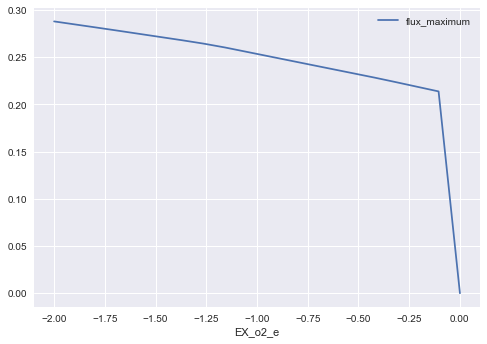

In [81]:
ppp_o2.plot(x='EX_o2_e', y='flux_maximum')